In [3]:
import math
import warnings

import matplotlib.pyplot as plt
import numpy as np
import palettable
import pandas as pd
import pybedtools
import statsmodels.api as sm
from liftover import get_lifter
from matplotlib import patches
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from scipy import stats

bold_10 = palettable.cartocolors.qualitative.Bold_10.mpl_colors

from scripts import aesthetics, sv_plot

aesthetics.activate_paper_rcParams()

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)

%reload_ext autoreload
%autoreload 2

# MYCN and 16p Neuroblastoma

Similar to EWSR1-FLI1, MYCN is somatically amplified in a subset of neuroblastoma (although its prevalence is significantly lower than Ewing's).

The logic here is that perhaps there is something similar happening. There are a few literature notable cases in this context. In particular, there's this paper: https://pubmed.ncbi.nlm.nih.gov/31474320/. Which implicates both a MYCN (chr2) amplification and a 16p11 deletion. We'll take a look at these loci.

__Note:__ The paper listed above actually collapsed large CNVs. We'll need to think about whether that is necessary here.

# Determine MYCN structure

In [4]:
gtf = pd.read_csv(
    "https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_43/gencode.v43.basic.annotation.gtf.gz",
    comment="#",
    sep="\t",
    header=None,
    names=[
        "seqname",
        "source",
        "feature",
        "start",
        "end",
        "score",
        "strand",
        "frame",
        "attribute",
    ],
)

In [5]:
# MYCN-201 is the canonical splice variant
gene_gtfs = {}
gene_attrs = {"MYCN": "MYCN-201"}
for g, g_attr in gene_attrs.items():

    # extract all elements of the gene
    gene_gtfs[g] = gtf[(gtf["attribute"].str.contains(g_attr))]

# save memory
del gtf

# Load in SVs and samples

In [6]:
svs = pd.read_csv(
    "gs://vanallen-pedsv-analysis/beds/PedSV.v2.3.case_control_cohort.analysis_samples.sites.bed.gz",
    sep="\t",
)

dosages = pd.read_csv(
    "gs://vanallen-pedsv-analysis/beds/PedSV.v2.3.case_control_cohort.analysis_samples.allele_dosages.bed.gz",
    sep="\t",
    index_col=False,
)

/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (6,34,35,37,39,41,45,46,47,48,72,73,87,88,106,107,121,122,136,137,155,156,170,171,185,186,204,205,219,220,234,235,253,254,268,269,283,284,302,303,317,318,332,333,351,352,366,367,381,382,400,401,415,416,430,431,449,450,464,465,479,480,498,499,513,514,528,529,547,548,562,563,577,578,596,597,645,646,647,648,649,650,690,691,692,693,694,695,713,714,728,729,743,744,758,759,773,774,788,789,803,804,818,819,833,834,848,849,863,864,878,879,893,894,908,909,923,924,931,937,943) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
metadata = pd.read_csv(
    "gs://vanallen-pedsv-analysis/sample_info/PedSV.v2.3.cohort_metadata.w_control_assignments.tsv.gz",
    sep="\t",
)

case_control_samples = pd.read_csv(
    "gs://vanallen-pedsv-analysis/sample_info/PedSV.v2.3.case_control_analysis_cohort.samples.list",
    header=None,
)[0].to_list()

# extract out the samples prsent in the dosage matrix
nbl_samples = metadata[(metadata["disease"] == "neuroblastoma") & (metadata['study_phase'] == 'case_control')]["entity:sample_id"].to_list()
nbl_samples = sorted(set(case_control_samples) & set(nbl_samples))

control_samples = metadata[(metadata["neuroblastoma_control"]) & (metadata['study_phase'] == 'case_control')]["entity:sample_id"].to_list()
control_samples = sorted(set(case_control_samples) & set(control_samples))

# create a new sex column for modeling, XY = 1
metadata["sex"] = (metadata["chrX_CopyNumber"].round() < 2).astype(int)

len(nbl_samples), len(control_samples)

(447, 2032)

And we subset the dosages to just these samples:

In [8]:
dosages = dosages[['#chr', 'start', 'end', 'ID'] + nbl_samples + control_samples]

We also remove all SVs that have no counts in genotyped samples. We don't care about these.

In [9]:
# identify the counts of each SV
sv_counts = dosages.iloc[:, 4:].fillna(0).sum(axis = 1)

# subset down SVs and dosages
svs = svs[sv_counts != 0]
dosages = dosages[sv_counts != 0]

In [10]:
svs.shape, dosages.shape

((161361, 952), (161361, 2483))

# Identifying regions of interest

Unlike EWSR1-FLI1, we aren't simply looking at genes here. The germline amplification noted in that paper is incredibly large, as large as 10 Mb. Similarly, the noted microdeletion on 16p is nearly 10 Mb in size.

This is tricky because I don't know how GATK handles CNVs--I assume it uses read depth, in which case these events should easily span MYCN and a narrow region on 16p, but we'll cast a large net either way.

Luckily, this paper did us a favor and categorized their large CNVs:

In [11]:
large_nbl_cnvs = pd.read_excel('ref/10.1016-j.ajhg.2019.07.020-supplementary/1-s2.0-S0002929719303039-mmc2.xlsx', skiprows=3)
large_nbl_cnvs['start'] = large_nbl_cnvs['Region'].apply(lambda region: region.split(':')[1].split('-')[0].replace(',', '')).astype(int)
large_nbl_cnvs['end'] = large_nbl_cnvs['Region'].apply(lambda region: region.split(':')[1].split('-')[1].replace(',', '')).astype(int)
large_nbl_cnvs['chrom'] = large_nbl_cnvs['Region'].apply(lambda region: region.split(':')[0])

We'll be taking a look at two: `chr16:p11.2` and `chr2:p25.1-p24.2`. MYCN is located on `chr2:16,080,672-16,087,126`, or `2p24.3`. The chr16 microdeletion has variable location, but it looks as though it primarily appears around 30 Mb along chr16.

## MYCN

Some digging around in this dataset shows that there actually isn't a reproducible MYCN amplification. Only one sample has one in the paper, and that sample is apparently not given in this dataset.

In [12]:
large_nbl_cnvs.query('chrom == "chr2" & start > 1200000').sort_values(by = 'start').iloc[5:10]

,Chip Barcode,USIa,Group,Region,Event,Length,Cytoband,Probe Median,Probe Count,Minimum Size,Minimum Region,Maximum Size,Maximum Region,Call P-value,start,end,chrom
102,1562857594_A,PAKHSL,Discovery Cohort Case,"chr2:4,114,403-4,651,344",CN Loss,536942,p25.3 - p25.2,-0.636486,74,526241,"chr2:4,124,656-4,650,896",547642,"chr2:4,104,151-4,651,792",3.970000e-140,4114403,4651344,chr2
3190,6205470038_R03C01,Control,Replication Cohort Control,"chr2:30,702,846-32,771,540",CN Gain,2068695,p23.1 - p22.3,0.215332,430,2063126,"chr2:30,703,971-32,767,096",2074263,"chr2:30,701,722-32,775,984",8.800000e-241,30702846,32771540,chr2
2917,6092196190_R06C02,Control,Replication Cohort Control,"chr2:32,019,597-33,071,570",CN Gain,1051974,p23.1 - p22.3,0.194516,123,1042433,"chr2:32,020,049-33,062,481",1061514,"chr2:32,019,146-33,080,659",4.850000e-32,32019597,33071570,chr2
1299,4067202054_B,Control,Discovery Cohort Control,"chr2:32,521,450-33,322,967",CN Gain,801518,p22.3,0.255594,112,780624,"chr2:32,540,334-33,320,957",822413,"chr2:32,502,566-33,324,978",6.730000e-42,32521450,33322967,chr2
3951,7930622149_R05C02,Control,Replication Cohort Control,"chr2:32,538,503-33,340,399",CN Gain,801897,p22.3,0.227224,134,798189,"chr2:32,541,438-33,339,626",805605,"chr2:32,535,568-33,341,172",1.480000e-55,32538503,33340399,chr2


We can see that the given CNVs jump from 4 Mb to 30 Mb, essentially skipping MYCN.

## 16p microdeletion

This one is a little harder to wrangle, since we don't have exact genomic coordinates.

In [13]:
nbl_16p_microdel = large_nbl_cnvs[(large_nbl_cnvs['chrom'] == 'chr16') &
                                  (large_nbl_cnvs['Cytoband'] == 'p11.2')]
nbl_16p_microdel.shape

(47, 17)

In [14]:
nbl_16p_microdel.head(2)

,Chip Barcode,USIa,Group,Region,Event,Length,Cytoband,Probe Median,Probe Count,Minimum Size,Minimum Region,Maximum Size,Maximum Region,Call P-value,start,end,chrom
42,1552042589_A,PANWZA,Discovery Cohort Case,"chr16:29,529,922-30,270,939",CN Loss,741018,p11.2,-0.526034,36,530466,"chr16:29,647,342-30,177,807",951569,"chr16:29,412,503-30,364,071",1.060000e-94,29529922,30270939,chr16
63,1557556242_A,PAMXAW,Discovery Cohort Case,"chr16:29,529,922-30,270,939",CN Gain,741018,p11.2,0.241063,36,530466,"chr16:29,647,342-30,177,807",951569,"chr16:29,412,503-30,364,071",4.540000e-12,29529922,30270939,chr16


Some digging into this and the paper suggests that the "critical region" is `chr16:29,529,922-30,270,939`. This is the region that we'll define.

Unfortunately, we do need to lift this region over, as it was defined by this paper that used hg19.

In [15]:
# do the liftover
hg19_to_hg38 = get_lifter("hg19", "hg38")
hg19_to_hg38.query('chr16', 29529922), hg19_to_hg38.query('chr16', 30270939)


([('chr16', 29518601, '+')], [('chr16', 30259618, '+')])

So `chr16:295186010-30259618`

In [16]:
genes = {
    "MYCN": ["chr2", 15940550, 15947007],
    "16pmicrodel": ["chr16", 29518601, 30259618],
}

gene_locs = pd.DataFrame.from_dict(
    genes, orient="index", columns=["chrom", "start", "end"]
)
gene_locs["gene"] = genes.keys()

In [17]:
gene_locs

,chrom,start,end,gene
MYCN,chr2,15940550,15947007,MYCN
16pmicrodel,chr16,29518601,30259618,16pmicrodel


# Isolate the SVs in this region

In [18]:
# get 0.5 Mb on either side of the gene
window_size = 1e6

# expand the gene "locations" to include this window
expanded_gene_locs = gene_locs.copy()
expanded_gene_locs["start"] = (expanded_gene_locs["start"] - window_size / 2).astype(
    int
)
expanded_gene_locs["end"] = (expanded_gene_locs["end"] + window_size / 2).astype(int)

# do the intersection with pybedtools. pybedtools requires either a temp file or
# a string, and we choose the latter.
expanded_gene_bed = pybedtools.BedTool(
    expanded_gene_locs.to_csv(sep="\t", index=False, header=False), from_string=True
)
sv_bed = pybedtools.BedTool(
    svs[["#chrom", "start", "end", "name"]].to_csv(sep="\t", index=False, header=False),
    from_string=True,
)

svs_in_regions = sv_bed.intersect(expanded_gene_bed, wo=True)
svs_in_regions = svs_in_regions.to_dataframe()

# drop unnecessary columns
svs_in_regions = svs_in_regions.iloc[:, [0, 1, 2, 3, 7]].copy()
svs_in_regions.columns = ["chrom", "start", "end", "name", "gene"]

In [19]:
svs_in_regions

,chrom,start,end,name,gene
0,chr2,15443841,15443842,PedSV.v2.3_INS_chr2_454,MYCN
1,chr2,15453979,15455198,PedSV.v2.3_DUP_chr2_696,MYCN
2,chr2,15463104,15465416,PedSV.v2.3_DEL_chr2_1654,MYCN
3,chr2,15481480,15481611,PedSV.v2.3_DEL_chr2_1655,MYCN
4,chr2,15611606,15611739,PedSV.v2.3_DEL_chr2_1664,MYCN
...,...,...,...,...,...
196,chr16,30725235,30725236,PedSV.v2.3_INS_chr16_723,16pmicrodel
197,chr16,30725250,30725312,PedSV.v2.3_DUP_chr16_1169,16pmicrodel
198,chr16,30749020,30749182,PedSV.v2.3_DEL_chr16_3312,16pmicrodel
199,chr16,30749492,30749608,PedSV.v2.3_DEL_chr16_3313,16pmicrodel


We "quickly" nab complex SVs as well

In [20]:
# get all complex SVs
complex_svs = svs[(svs["svtype"] == "CPX")][
    [
        "name",
        "#chrom",
        "start",
        "end",
        "svtype",
        "CHR2",
        "CPX_INTERVALS",
        "CPX_TYPE",
        "END",
    ]
].copy()

# split each component SV--represented by CPX_INTERVALS--into their own rows
complex_svs = complex_svs.assign(
    intervals=complex_svs["CPX_INTERVALS"].str.split(",")
).explode("intervals")

# convert this data to a proper bed for intersection
complex_sv_bed = complex_svs[["name", "intervals"]].copy()
complex_sv_bed["chrom"] = complex_sv_bed["intervals"].apply(
    lambda interv: interv.split(":")[0].split("_")[-1]
)
complex_sv_bed["start"] = complex_sv_bed["intervals"].apply(
    lambda interv: interv.split(":")[-1].split("-")[0]
)
complex_sv_bed["end"] = complex_sv_bed["intervals"].apply(
    lambda interv: interv.split(":")[-1].split("-")[1]
)

# convert to a bedtool
complex_sv_bed = pybedtools.BedTool(
    complex_sv_bed[["chrom", "start", "end", "name"]].to_csv(
        sep="\t", index=False, header=False
    ),
    from_string=True,
)

# do our intersection
complex_svs_in_regions = complex_sv_bed.intersect(expanded_gene_bed, wo=True)

complex_svs_in_regions = complex_svs_in_regions.to_dataframe()

# drop unnecessary columns
if len(complex_svs_in_regions):
    complex_svs_in_regions = complex_svs_in_regions.iloc[:, [0, 1, 2, 3, 7]].copy()
    complex_svs_in_regions.columns = ["chrom", "start", "end", "name", "gene"]
else:
    complex_svs_in_regions = pd.DataFrame(
        columns=["chrom", "start", "end", "name", "gene"]
    )

In [21]:
complex_svs_in_regions

,chrom,start,end,name,gene
0,chr2,16079849,16081075,PedSV.v2.3_CPX_chr2_40,MYCN
1,chr2,16080529,16081075,PedSV.v2.3_CPX_chr2_40,MYCN
2,chr16,29226778,29226850,PedSV.v2.3_CPX_chr16_65,16pmicrodel
3,chr16,29226778,29227255,PedSV.v2.3_CPX_chr16_65,16pmicrodel


In [22]:
# the number of complex SVs recovered, and the number that were in our original simple overlap
len(set(complex_svs_in_regions["name"])), len(
    set(complex_svs_in_regions["name"]) & set(svs_in_regions["name"])
)

(2, 2)

Again, this process picks up only one new SV--a distributed duplication.

## Subsetting and QC'ing SVs in gene regions

To save memory, we subset the big SV and dosage matrices down to just these samples and SVs.

In [23]:
# keep the gene names
svs_in_regions_names = pd.concat(
    [svs_in_regions[["name", "gene"]], complex_svs_in_regions[["name", "gene"]]]
)

# drop duplicates - complex SVs that were picked up twice
svs_in_regions_names = svs_in_regions_names.drop_duplicates(subset = ['name'])

In [24]:
len(svs_in_regions_names)

201

So a decent number of SVs in this dataset fall within this region.


In [25]:
svs[svs['name'].isin(svs_in_regions_names['name'])]['svtype'].value_counts()

DEL           137
DUP            33
INS            10
INS:ME:ALU      9
INS:ME:SVA      4
CNV             4
CPX             3
INV             1
Name: svtype, dtype: int64

There's some CNVs - interesting

We fetch all these SVs from the original dataset now and apply some filters:

In [26]:
# subset
subset_svs = svs.set_index("name").loc[svs_in_regions_names["name"]].reset_index()
subset_svs.insert(0, "gene", svs_in_regions_names["gene"].values)

# convert AF to float. We overwrite AF for CNV to 1 arbitrarily
subset_svs['AF'] = subset_svs['AF'].apply(lambda af: float(af) if af != 'None' else 1)

# how many are PASS?
print(subset_svs["FILTER"].value_counts())

# and how many are rare?
print("\nRare:\n", (subset_svs["AF"] < 0.01).value_counts())

PASS            197
MULTIALLELIC      4
Name: FILTER, dtype: int64

Rare:
 True     165
False     36
Name: AF, dtype: int64


In [27]:
print("\nRare:\n", (subset_svs.query('gene == "MYCN"')["AF"] < 0.01).value_counts())


Rare:
 True     42
False    19
Name: AF, dtype: int64


That's not bad. How many pass the filter, are rare, and are present in the dosage matrix?

We'll add in a quick QC method to remove some suspect SVs that Ryan is concerned about.

In [28]:
subset_svs.groupby(['gene'])['svtype'].value_counts()

gene         svtype    
16pmicrodel  DEL           99
             DUP           21
             INS            6
             CNV            4
             INS:ME:ALU     4
             INS:ME:SVA     3
             CPX            2
             INV            1
MYCN         DEL           38
             DUP           12
             INS:ME:ALU     5
             INS            4
             CPX            1
             INS:ME:SVA     1
Name: svtype, dtype: int64

In [29]:
subset_svs.query('svtype == "CNV"')

,gene,name,#chrom,start,end,svtype,AC,AF,ALGORITHMS,AN,BOTHSIDES_SUPPORT,CHR2,CNV_CONCORDANCE,CPX_INTERVALS,CPX_TYPE,END,END2,EVIDENCE,FAILED_COHORT_COMPARISONS,GENOTYPE_CONCORDANCE,GROUPWISE_MASKED_GENOTYPES,HET_PPV,HET_SENSITIVITY,HG38_REF_PATCH_LOCUS,HIGH_SR_BACKGROUND,HOMVAR_PPV,HOMVAR_SENSITIVITY,MINSL,NCN,NCR,NON_REF_GENOTYPE_CONCORDANCE,OLD_ID,PCRMINUS_NCR,PESR_GT_OVERDISPERSION,PREDICTED_BREAKEND_EXONIC,PREDICTED_COPY_GAIN,PREDICTED_DUP_PARTIAL,PREDICTED_INTERGENIC,PREDICTED_INTRAGENIC_EXON_DUP,PREDICTED_INTRONIC,PREDICTED_INV_SPAN,PREDICTED_LOF,PREDICTED_MSV_EXON_OVERLAP,PREDICTED_NEAREST_TSS,PREDICTED_NONCODING_BREAKPOINT,PREDICTED_NONCODING_SPAN,PREDICTED_PARTIAL_EXON_DUP,PREDICTED_PROMOTER,PREDICTED_TSS_DUP,PREDICTED_UTR,...,SAS_N_HET,SAS_N_HOMALT,SAS_FREQ_HOMREF,SAS_FREQ_HET,SAS_FREQ_HOMALT,SAS_CN_NUMBER,SAS_CN_COUNT,SAS_CN_FREQ,SAS_CN_NONREF_COUNT,SAS_CN_NONREF_FREQ,EUR_AN,EUR_AC,EUR_AF,EUR_N_BI_GENOS,EUR_N_HOMREF,EUR_N_HET,EUR_N_HOMALT,EUR_FREQ_HOMREF,EUR_FREQ_HET,EUR_FREQ_HOMALT,EUR_CN_NUMBER,EUR_CN_COUNT,EUR_CN_FREQ,EUR_CN_NONREF_COUNT,EUR_CN_NONREF_FREQ,POPMAX_AF,POPMAX_FREQ_HOMREF,POPMAX_FREQ_HET,POPMAX_FREQ_HOMALT,POPMAX_CN_FREQ,POPMAX_CN_NONREF_FREQ,case_control_POPMAX_AF,case_control_POPMAX_FREQ_HOMREF,case_control_POPMAX_FREQ_HET,case_control_POPMAX_FREQ_HOMALT,case_control_POPMAX_CN_FREQ,case_control_POPMAX_CN_NONREF_FREQ,trio_POPMAX_AF,trio_POPMAX_FREQ_HOMREF,trio_POPMAX_FREQ_HET,trio_POPMAX_FREQ_HOMALT,trio_POPMAX_CN_FREQ,trio_POPMAX_CN_NONREF_FREQ,gnomad_v3.1_sv_POPMAX_AF,gnomad_v3.1_sv_POPMAX_FREQ_HOMREF,gnomad_v3.1_sv_POPMAX_FREQ_HET,gnomad_v3.1_sv_POPMAX_FREQ_HOMALT,gnomad_v3.1_sv_POPMAX_CN_FREQ,gnomad_v3.1_sv_POPMAX_CN_NONREF_FREQ,FILTER
101,16pmicrodel,PedSV.v2.3_CNV_chr16_39,chr16,29442486,29478487,CNV,0,1.0,depth,0,False,NaN,NaN,NaN,NaN,29478487,NaN,RD,NaN,NaN,False,NaN,NaN,False,False,NaN,NaN,NaN,0,0.0,NaN,All_20_Batches.chr16.final_cleanup_CNV_chr16_39,NaN,False,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,"BOLA2,SLX1B,SULT1A4",NaN,"ewing_chromHMM15_Quies,neuroblastoma_chromHMM1...","ewing_H3K27Ac_peak_unconserved,ewing_and_osteo...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,49.0,"0,0,6,30,13","0.0,0.0,0.12244900315999985,0.6122450232505798...",43.0,0.877551,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5366.0,"0,1,952,2873,1418,112,7,3","0.0,0.0001863590005086735,0.1774130016565323,0...",4414.0,0.822587,NaN,NaN,NaN,NaN,"0.0,0.0001863590005086735,0.39130398631095886,...",NaN,NaN,NaN,NaN,NaN,"0.0,0.00037900000461377203,0.1695690006017685,...",NaN,NaN,NaN,NaN,NaN,"0.0,0.0,0.39449501037597656,0.5964130163192749...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,MULTIALLELIC
104,16pmicrodel,PedSV.v2.3_CNV_chr16_40,chr16,29511000,29522001,CNV,0,1.0,depth,0,False,NaN,NaN,NaN,NaN,29522001,NaN,RD,NaN,NaN,False,NaN,NaN,False,False,NaN,NaN,NaN,0,0.0,NaN,All_20_Batches.chr16.final_cleanup_CNV_chr16_40,NaN,False,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NPIPB12,"ewing_chromHMM15_Quies,neuroblastoma_chromHMM1...",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,49.0,"0,0,18,31","0.0,0.0,0.36734700202941895,0.632652997970581",31.0,0.632653,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5366.0,"0,0,2608,2659,95,4","0.0,0.0,0.4860230088233948,0.4955269992351532,...",2758.0,0.513977,NaN,NaN,NaN,NaN,"0.0,0.0,0.7065219879150391,0.4955269992351532,...",NaN,NaN,NaN,NaN,NaN,"0.0,0.0,0.6750630140304565,0.4360330104827881,...",NaN,NaN,NaN,NaN,NaN,"0.0,0.0,0.6238530278205872,0.5532310009002686,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,MULTIALLELIC
159,16pmicrodel,PedSV.v2.3_CNV_chr16_42,chr16,30251800,30261001,CNV,0,1.0,depth,0,False,NaN,NaN,NaN,NaN,30261001,NaN,RD,NaN,NaN,False,NaN,NaN,False,False,NaN,NaN,NaN,0,0.0,NaN,All_20_Batches.chr16.final_cleanup_CNV_chr16_42,NaN,False,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NPIPB13,"ewing_chromHMM15_Quies,neuroblastoma_chromHMM1...",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,49.0,"0,0,13,32,4","0.0,0.0,0.2653059959411621,0.6530609726905823,...",36.0,0.734694,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5366.0,"0,0,1965,3115,280,5,1","0.0,0.0,0

So all the CNVs are the 16p microdels. We'll ignore these for right now.

In [31]:
svs["FILTER"].value_counts()

PASS            160788
MULTIALLELIC       573
Name: FILTER, dtype: int64

In [32]:
# only include SVs that pass the FILTER, are rare, and are in our dosage matrix
svs_to_keep = subset_svs[
    (
        (subset_svs["FILTER"] == "PASS")
        & (subset_svs["name"].isin(dosages["ID"].to_list()))
    )
].copy()

svs_to_keep["rare"] = svs_to_keep["AF"] < 0.01

svs_to_keep.shape

(197, 954)

In [33]:
svs_to_keep["svtype"].value_counts()

DEL           137
DUP            33
INS            10
INS:ME:ALU      9
INS:ME:SVA      4
CPX             3
INV             1
Name: svtype, dtype: int64

Text(0.5, 0, 'AF')

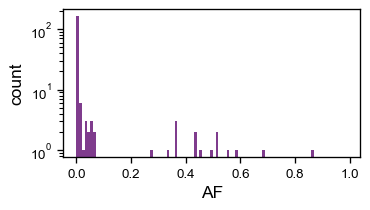

In [36]:
fig, ax = plt.subplots(1, figsize=(4, 2))
plt.hist(svs_to_keep["AF"], bins=np.arange(0, 1, 0.01))
plt.yscale("log")
plt.ylabel("count")
plt.xlabel("AF")

So there are some SVs in this region, and the vast majority are rare (unsurprisingly). We'll analyze them all together, but at some points keep rare separate.

## Extract sample dosages

Here we pull out the allele counts for each SV, so that we can determine case vs. control.

In [37]:
# we begin by subsetting the dosage matrix down to the SVs that we care about. This double counts SVs
# that affect more than one gene.
subset_dosages = dosages[dosages["ID"].isin(svs_to_keep["name"].to_list())].reset_index(
    drop=True
)

# we add in the information about which gene is affected (the first column is just the SV name, so we drop it)
subsetted_gene_dosages = (
    svs_to_keep[["name", "gene", "AF", "rare"]]
    .merge(subset_dosages, right_on="ID", left_on="name")
    .iloc[1:]
)

subsetted_gene_dosages.head(2)

,name,gene,AF,rare,#chr,start,end,ID,SJ006001,SJ006002,SJ006003,SJ006004,SJ006006,SJ006008,SJ006009,SJ006010,SJ006011,SJ006012,SJ006013,SJ006014,SJ006016,SJ006017,SJ006018,SJ006019,SJ006020,SJ006022,SJ006023,SJ006024,SJ006025,SJ006026,SJ006029,SJ006031,SJ006032,SJ006033,SJ006034,SJ006036,SJ006037,SJ006038,SJ006039,SJ006042,SJ006047,SJ006048,SJ006050,SJ006053,SJ006057,SJ006063,SJ006070,SJ006071,SJ006072,SJ006074,...,ssi_26179,ssi_26198,ssi_26199,ssi_26202,ssi_26209,ssi_26226,ssi_26237,ssi_26243,ssi_26246,ssi_26248,ssi_26258,ssi_26262,ssi_26267,ssi_26271,ssi_26288,ssi_26291,ssi_26292,ssi_26300,ssi_26301,ssi_26305,ssi_26324,ssi_26325,ssi_26326,ssi_26334,ssi_26336,ssi_26338,ssi_26340,ssi_26341,ssi_26342,ssi_26348,ssi_26355,ssi_26362,ssi_26365,ssi_26369,ssi_26372,ssi_26373,ssi_26376,ssi_26385,ssi_26393,ssi_26396,ssi_26401,ssi_26409,ssi_26411,ssi_26422,ssi_26442,ssi_26452,ssi_26453,ssi_26458,ssi_26459,ssi_26463
1,PedSV.v2.3_DUP_chr2_696,MYCN,0.000074,True,chr2,15453980,15455198,PedSV.v2.3_DUP_chr2_696,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,PedSV.v2.3_DEL_chr2_1654,MYCN,0.000148,True,chr2,15463105,15465416,PedSV.v2.3_DEL_chr2_1654,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Next, we devise two metrics for cases and controls--one listing the allele frequency of each SV and another listing the number of samples with an SV in the gene.

We need to convert the dosage (allele count) to allele frequencies

In [96]:
case_control_counts = []
case_control_samples_with_svs = []

for sample_group, label in zip(
    [nbl_samples, control_samples], ["cases", "controls"]
):

    # subset to these samples
    sample_dosages = subsetted_gene_dosages[
        ["name", "gene", "#chr", "start", "end", "AF", "rare"] + sample_group
    ]

    # first, count the SVs. This function counts the number of samples with each genotype.
    sv_counts = (
        sample_dosages[sample_group]
        .apply(lambda row: row.dropna().value_counts(), axis=1)
        .fillna(0)
        .astype(int)
    )

    # name columns to genotypes
    sv_counts.columns = f"{label}_" + sv_counts.columns.astype(int).astype(str)
    sv_counts["name"] = sample_dosages["name"]

    case_control_counts.append(sv_counts)

    # now count the number of samples with at least one SV around each gene.
    # we groupby gene, then determine whether each sample has an SV in that gene, then
    # count these samples up per gene.
    num_samples_with_svs = sample_dosages.groupby(["gene"]).apply(
        lambda group: (group[sample_group] > 0).any(axis=0).sum()
    )

    num_samples_with_svs.name = label + "_all"
    num_samples_with_svs = num_samples_with_svs / len(sample_group)
    case_control_samples_with_svs.append(num_samples_with_svs)

    # repeat for rare SVs
    num_samples_with_svs_rare = (
        sample_dosages.query("rare == True")
        .groupby(["gene"])
        .apply(lambda group: (group[sample_group] > 0).any(axis=0).sum())
    )

    num_samples_with_svs_rare.name = label + "_rare"
    num_samples_with_svs_rare = num_samples_with_svs_rare / len(sample_group)
    case_control_samples_with_svs.append(num_samples_with_svs_rare)

# merge
case_control_sv_counts = sample_dosages.iloc[:, :7].reset_index(drop=True)
for df in case_control_counts:
    case_control_sv_counts = case_control_sv_counts.merge(df)

case_control_sv_counts["midpoint"] = np.mean(
    case_control_sv_counts[["start", "end"]], axis=1
)

# and total up the sample counts
case_control_sample_counts = pd.DataFrame(case_control_samples_with_svs).T

In [97]:
case_control_sv_counts.head(2)

,name,gene,#chr,start,end,AF,rare,cases_0,cases_1,cases_2,controls_0,controls_1,controls_2,midpoint
0,PedSV.v2.3_DUP_chr2_696,MYCN,chr2,15453980,15455198,0.000074,True,447,0,0,2031,1,0,15454589.0
1,PedSV.v2.3_DEL_chr2_1654,MYCN,chr2,15463105,15465416,0.000148,True,447,0,0,2030,2,0,15464260.5


Next we add some columns for allele frequency.

In [98]:
for label in ["cases", "controls"]:

    # a quick check to see if there are non-0/1/2 genotypes
    columns = [col for col in case_control_sv_counts.columns if col.startswith(label)]
    assert columns == [f"{label}_{i}" for i in range(3)]

    alt = (case_control_sv_counts[columns] * np.array([0, 1, 2])).sum(axis=1)
    ref = case_control_sv_counts[columns].sum(axis=1) * 2
    case_control_sv_counts[f"AF_{label}"] = alt / ref

In [99]:
case_control_sv_counts.head(2)

,name,gene,#chr,start,end,AF,rare,cases_0,cases_1,cases_2,controls_0,controls_1,controls_2,midpoint,AF_cases,AF_controls
0,PedSV.v2.3_DUP_chr2_696,MYCN,chr2,15453980,15455198,0.000074,True,447,0,0,2031,1,0,15454589.0,0.0,0.000246
1,PedSV.v2.3_DEL_chr2_1654,MYCN,chr2,15463105,15465416,0.000148,True,447,0,0,2030,2,0,15464260.5,0.0,0.000492


In [100]:
case_control_sample_counts

,cases_all,cases_rare,controls_all,controls_rare
gene,,,,
16pmicrodel,0.997763,0.138702,1.0,0.147146
MYCN,1.000000,0.053691,1.0,0.078248


Any smoking guns in terms of SVs?

In [101]:
freq_diff = case_control_sv_counts["AF_cases"] - (case_control_sv_counts["AF_controls"])

case_control_sv_counts.iloc[freq_diff.sort_values(ascending=False).index].query('rare == True').head(4)

,name,gene,#chr,start,end,AF,rare,cases_0,cases_1,cases_2,controls_0,controls_1,controls_2,midpoint,AF_cases,AF_controls
88,PedSV.v2.3_DEL_chr16_3108,16pmicrodel,chr16,29285223,29285279,0.001726,True,423,8,0,2030,0,0,29285251.0,0.009281,0.000000
94,PedSV.v2.3_DEL_chr16_3116,16pmicrodel,chr16,29379954,29380259,0.004562,True,437,8,0,2011,12,0,29380106.5,0.008989,0.002966
31,PedSV.v2.3_DEL_chr2_1708,MYCN,chr2,16092661,16092804,0.005325,True,436,11,0,2000,31,1,16092732.5,0.012304,0.008120
138,PedSV.v2.3_DUP_chr16_1141,16pmicrodel,chr16,30064165,30064220,0.003921,True,441,4,1,2023,6,3,30064192.5,0.006726,0.002953


In [102]:
case_control_sv_counts.iloc[freq_diff.sort_values(ascending=False).index].tail(4)

,name,gene,#chr,start,end,AF,rare,cases_0,cases_1,cases_2,controls_0,controls_1,controls_2,midpoint,AF_cases,AF_controls
48,PedSV.v2.3_DUP_chr2_724,MYCN,chr2,16225124,16226720,0.869601,False,0,193,254,0,668,1364,16225922.0,0.784116,0.835630
42,PedSV.v2.3_DUP_chr2_721,MYCN,chr2,16143935,16143990,0.063092,False,432,14,1,1651,374,7,16143962.5,0.017897,0.095472
46,PedSV.v2.3_INS_chr2_470,MYCN,chr2,16148390,16148390,0.517543,False,229,196,17,0,1139,893,16148390.0,0.260181,0.719734
43,PedSV.v2.3_DEL_chr2_1723,MYCN,chr2,16146439,16146505,0.430917,False,293,132,22,121,914,997,16146472.0,0.196868,0.715551


# Where do these SVs fall relative to MYCN?

We're going to shelve this microdeletion for now, as I need to understand how such a large deletion would be represented. 

This is a little hamfisted, but we'll split by common SVs and then just rare.

In [103]:
expanded_gene_locs = expanded_gene_locs.iloc[[0], :]

/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator


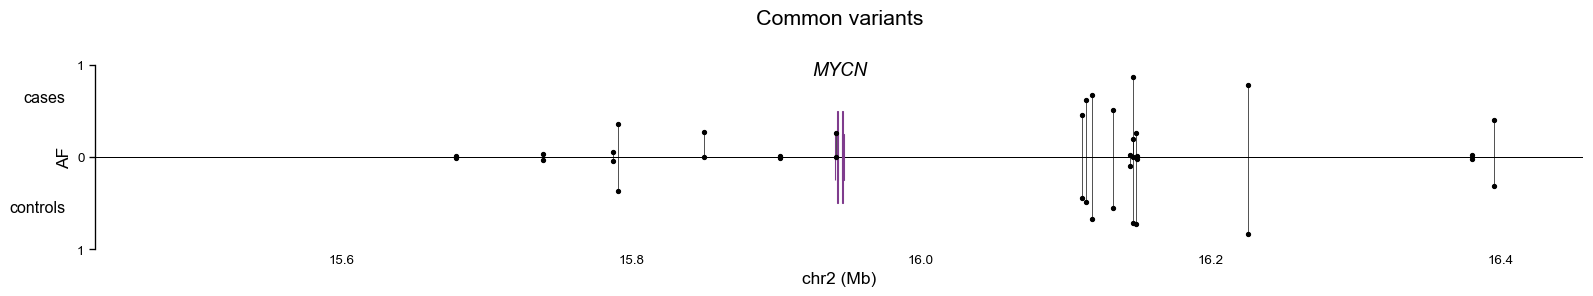

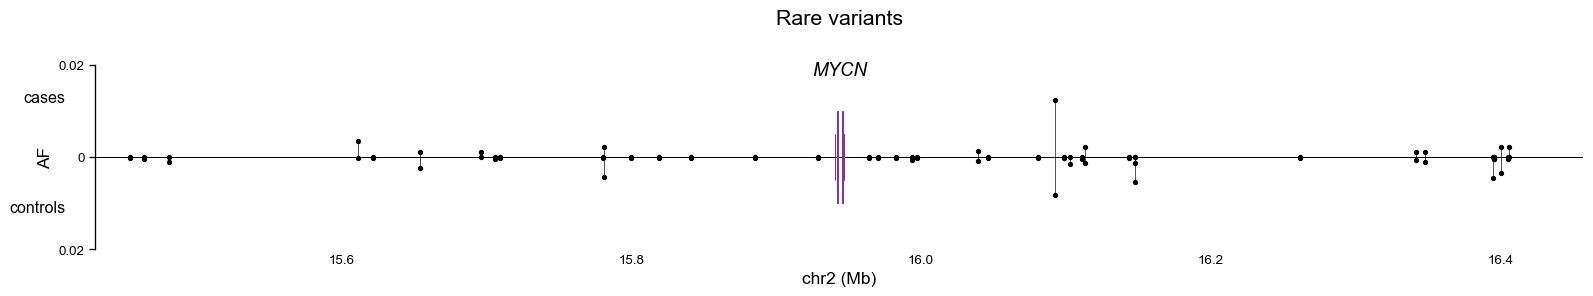

In [105]:
gene = 'MYCN'
for plot in ["common", "rare"]:

    fig, ax = plt.subplots(
        len(expanded_gene_locs),
        1,
        figsize=(20, 2.5 * len(expanded_gene_locs)),
        gridspec_kw={"hspace": 0.5},
    )

    g_gtf = gene_gtfs[g]

    # plot the genetic elements
    feature_colors = {"exon": bold_10[0], "CDS": bold_10[0]}
    window = expanded_gene_locs.loc[g, ["start", "end"]].values
    feature_span = {"exon": 0.25, "CDS": 0.5}

    ax = sv_plot.plot_genomic_elements(
        ax,
        g_gtf,
        window=window,
        feature_span=feature_span,
        feature_colors=feature_colors,
        label=False,
    )
    aesthetics.strip_axis(ax=ax, x="label", y="ignore")

    contig = expanded_gene_locs.loc[g, "chrom"]
    ax.set_title(g, fontstyle="italic", y=0.9)

    # plot the range of interest
    ax.set_xlim(
        expanded_gene_locs.loc[g, ["start", "end"]].values
        + np.array([-10000, 10000])
    )
    ax.spines["bottom"].set_bounds(
        expanded_gene_locs.loc[g, ["start", "end"]].values
    )

    # add labels
    ax.text(s="cases", x=-0.02, y=0.8, transform=ax.transAxes, ha="right")
    ax.text(s="controls", x=-0.02, y=0.2, transform=ax.transAxes, ha="right")

    # switch to Mb
    ax.set_xticklabels(ax.get_xticks() / 1e6)
    ax.set_xlabel(f"{contig} (Mb)")

    # next we add in the SVs. First subset to the SVs in question
    if plot == "common":
        plot_svs = case_control_sv_counts.query("rare == False").copy()
    elif plot == "rare":
        plot_svs = case_control_sv_counts.query("rare == True").copy()

    gene_data = plot_svs[plot_svs["gene"] == gene]

    # get the max frequency
    max_freq = gene_data[["AF_cases", "AF_controls"]].max().max()

    if plot == "common":
        rounded_max = 1
    if plot == "rare":
        rounded_max = math.ceil(max_freq * 100) / 100

    # its much easier to plot everything at once with plt.stem, but that function sucks
    # we scale the frequency to fill the plot
    case_y = (gene_data["AF_cases"]) / rounded_max
    control_y = (gene_data["AF_controls"]) / rounded_max

    # add the points
    ax.scatter(x=gene_data["midpoint"], y=case_y, color="black", s=10, zorder=3)
    ax.scatter(x=gene_data["midpoint"], y=-control_y, color="black", s=10, zorder=3)

    # add the lollipop lines
    for loc, case, control in zip(gene_data["midpoint"], case_y, control_y):
        ax.plot(
            [loc, loc],
            [case, -control],
            color="black",
            linewidth=0.5,
            zorder=3,
        )

    ax.set_yticks([-1, 0, 1])
    ax.set_yticklabels([rounded_max, 0, rounded_max])
    ax.set_ylabel("AF")

    # add a title - can't use suptitle because that doesn't center over the gene
    ax.text(
        s=plot.capitalize() + " variants",
        x=0.5,
        y=1.2,
        transform=ax.transAxes,
        ha="center",
        va="bottom",
        fontsize=16,
    )

    fig.savefig(f"images/mycn-discovery-{plot}.png")

Interesting--definitely a ton of possible variants that could be implicated.

# A quick burden test

This is probably going to be significant, but we'll check anyway.

In [106]:
columns = [
    "entity:sample_id",
    "disease",
    "sex",
] + [col for col in metadata.columns if col in ['PC1', 'PC2', 'PC3']]

model_data = metadata[
    metadata["entity:sample_id"].isin(nbl_samples + control_samples)
][columns].set_index("entity:sample_id")

# annoying reformatting
model_data["disease"] = model_data["disease"].replace({"neuroblastoma": 1, "control": 0})

Now we determine the dosages

In [107]:
# for rare, common, and combined variants, we count
for rare in [True, False, 'combined']:

    if rare in [True, False]:
        gene_svs = subsetted_gene_dosages[
            (subsetted_gene_dosages["rare"] == rare)
            & (subsetted_gene_dosages["gene"] == 'MYCN')
        ]
        label = 'rare ' + gene if rare else 'common ' + gene
    elif rare == "combined":
        gene_svs = subsetted_gene_dosages[
            (subsetted_gene_dosages["gene"] == gene)
        ]
        label = 'rare + common ' + gene

    sv_counts = (gene_svs[nbl_samples + control_samples] > 0).sum(axis=0)

    model_data.loc[sv_counts.index, label] = sv_counts

Now we run the model

In [108]:
for svtype in ['rare', 'common', 'rare + common']:
        
    column = svtype + ' ' + 'MYCN'

    # run the model
    endog = model_data["disease"]
    exog = sm.tools.add_constant(model_data[[column] + columns[2:]])
    model = sm.Logit(
        endog,
        exog,
    ).fit(disp=0)

    coeff = model.params[1]
    p = model.pvalues[1]
    print('SV burden', svtype, gene, 'coeff:', coeff, 'p:', p)
    
    # also try a one-hot encoding
    exog[column] = (model_data[column] > 0).astype(int)

    try:
        one_hot_model = sm.Logit(
            endog,
            exog,
        ).fit(disp=0)
    except:
        print('Model failed')
        continue

    coeff = one_hot_model.params[1]
    p = one_hot_model.pvalues[1]
    print("SV one hot", svtype, gene, 'coeff:', coeff, 'p:', p)

SV burden rare MYCN coeff: -0.18634636928190212 p: 0.38913471442545833
SV one hot rare MYCN coeff: -0.21246077464867735 p: 0.3825491272781544
SV burden common MYCN coeff: 0.32570725300030867 p: 2.407247735088144e-15
Model failed
SV burden rare + common MYCN coeff: 0.30428728890556644 p: 2.811573186114287e-14
Model failed


# Individual SV analysis

Here we'll go through each SV and run a logit model, incorporating the same variables above, except time we'll use genotype.

In [109]:
columns = [
    "entity:sample_id",
    "disease",
    "sex",
] + [col for col in metadata.columns if col in ['PC1', 'PC2', 'PC3']]

model_data = metadata[
    metadata["entity:sample_id"].isin(nbl_samples + control_samples)
][columns].set_index("entity:sample_id")

# annoying reformatting
model_data["disease"] = model_data["disease"].replace({"neuroblastoma": 1, "control": 0})

In [110]:
model_data['disease'].value_counts()

0    2032
1     447
Name: disease, dtype: int64

Now we add the genotypes to this model data.

In [111]:
sv_dosages = subsetted_gene_dosages.set_index("name")[nbl_samples + control_samples]
model_data.loc[sv_dosages.columns, list(sv_dosages.index)] = sv_dosages.T

Next we simply loop through the SVs and run the model.

In [112]:
sv_models = {}
sv_results = []

for sv in sv_dosages.index:

    sv_model_data = model_data[columns[1:] + [sv]]

    # drop samples that could not be genotyped. This inherently introduces bias, so we keep track of the number of samples dropped.
    sv_model_data_nonna = sv_model_data.dropna(subset=[sv]).copy()
    dropped_samples = set(sv_model_data.index) - set(sv_model_data_nonna.index)
    num_cases_dropped = len(set(nbl_samples) & dropped_samples)
    num_controls_dropped = len(set(control_samples) & dropped_samples)

    # statsmodels doesn

    # run the model
    try:
        endog = sv_model_data_nonna["disease"]
        exog = sm.tools.add_constant(sv_model_data_nonna[[sv] + columns[2:]])

        # suppress some failure warnings
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model = sm.Logit(
                endog=endog,
                exog=exog,
            ).fit(disp=0, method="bfgs", maxiter=1000)

        # store
        sv_models[sv] = model
        sv_results.append(
            [
                sv,
                model.pvalues[1],
                model.params[1],
                num_cases_dropped,
                num_controls_dropped,
            ]
        )

    except:
        sv_models[sv] = "fail"

sv_results = pd.DataFrame(
    sv_results,
    columns=["name", "p", "coeff", "num_cases_dropped", "num_controls_dropped"],
).set_index("name")

In [113]:
sv_results.head(2)

,p,coeff,num_cases_dropped,num_controls_dropped
name,,,,
PedSV.v2.3_DUP_chr2_696,0.779139,-4.055896,0,0
PedSV.v2.3_DEL_chr2_1654,0.854562,-6.356616,0,0


In [114]:
case_control_sv_counts = case_control_sv_counts.merge(sv_results.reset_index()[['name', 'p', 'coeff']], on = ['name'])

In [115]:
case_control_sv_counts.query('gene == "MYCN" & p < 0.05')

,name,gene,#chr,start,end,AF,rare,cases_0,cases_1,cases_2,controls_0,controls_1,controls_2,midpoint,AF_cases,AF_controls,p,coeff
3,PedSV.v2.3_DEL_chr2_1664,MYCN,chr2,15611607,15611739,0.001341,True,426,3,0,1947,1,0,15611673.0,0.003497,0.000257,1.482700e-02,2.885819
22,PedSV.v2.3_DEL_chr2_1698,MYCN,chr2,15941541,15941792,0.039173,False,191,203,1,2031,1,0,15941666.5,0.259494,0.000246,1.136217e-14,7.794697
37,PedSV.v2.3_DUP_chr2_718,MYCN,chr2,16113712,16113862,0.588179,False,22,293,131,120,1826,86,16113787.0,0.622197,0.491634,5.600836e-37,1.816998
39,PedSV.v2.3_DEL_chr2_1719,MYCN,chr2,16131505,16133768,0.553735,False,27,374,31,13,1772,218,16132636.5,0.504630,0.551173,4.843153e-07,-0.963618
40,PedSV.v2.3_DEL_chr2_1721,MYCN,chr2,16143101,16149001,0.435004,False,8,84,290,1881,12,0,16146051.0,0.869110,0.003170,2.316114e-41,7.883164
42,PedSV.v2.3_DUP_chr2_721,MYCN,chr2,16143935,16143990,0.063092,False,432,14,1,1651,374,7,16143962.5,0.017897,0.095472,6.729087e-12,-1.791221
43,PedSV.v2.3_DEL_chr2_1723,MYCN,chr2,16146439,16146505,0.430917,False,293,132,22,121,914,997,16146472.0,0.196868,0.715551,7.947976e-110,-2.609024
46,PedSV.v2.3_INS_chr2_470,MYCN,chr2,16148390,16148390,0.517543,False,229,196,17,0,1139,893,16148390.0,0.260181,0.719734,3.693677e-63,-4.288730
48,PedSV.v2.3_DUP_chr2_724,MYCN,chr2,16225124,16226720,0.869601,False,0,193,254,0,668,1364,16225922.0,0.784116,0.835630,3.682891e-05,-0.443541
56,PedSV.v2.3_INS_chr2_476,MYCN,chr2,16395357,16395357,0.369259,False,94,349,3,742,1290,0,16395357.0,0.397982,0.317421,1.964505e-10,0.809232


Next we'll try plotting

/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator


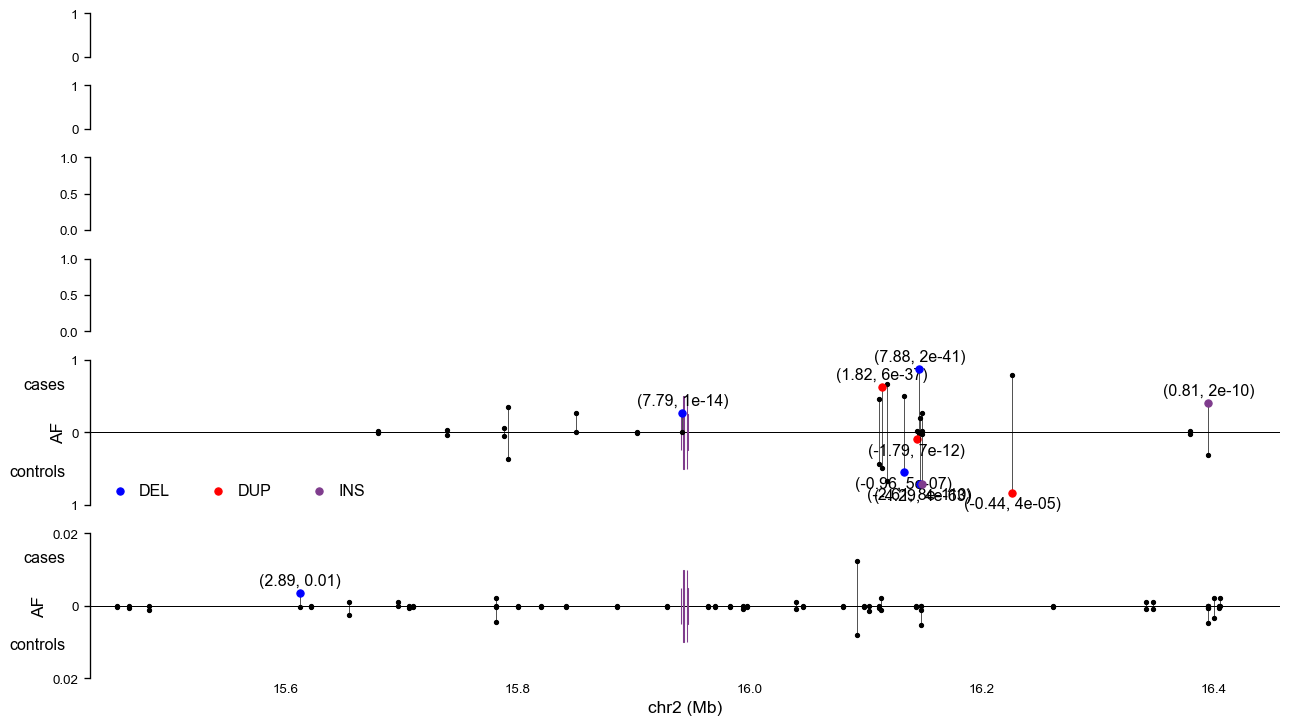

In [116]:
gene = 'MYCN'
sv_colors = {"DEL": "blue", "DUP": "red", "INS": bold_10[0]}
sv_plot_storage = []

fig, axes = plt.subplots(
    6,
    1,
    figsize=(16,  9),
    gridspec_kw={"hspace": 0.33, 'height_ratios': [3, 3, 5, 5, 10, 10]},
)

for plot in ["common", "rare"]:
    
    if plot == 'common':
        ax = axes[-2]
    else:
        ax = axes[-1]

    g_gtf = gene_gtfs[g]

    # plot the genetic elements
    feature_colors = {"exon": bold_10[0], "CDS": bold_10[0]}
    window = expanded_gene_locs.loc[g, ["start", "end"]].values
    feature_span = {"exon": 0.25, "CDS": 0.5}

    ax = sv_plot.plot_genomic_elements(
        ax,
        g_gtf,
        window=window,
        feature_span=feature_span,
        feature_colors=feature_colors,
        label=False,
    )
    aesthetics.strip_axis(ax=ax, x="label", y="ignore")

    contig = expanded_gene_locs.loc[g, "chrom"]
    # ?ax.set_title(g, fontstyle="italic", y=0.9)

    # plot the range of interest
    ax.set_xlim(
        expanded_gene_locs.loc[g, ["start", "end"]].values
        + np.array([-10000, 10000])
    )
    ax.spines["bottom"].set_bounds(
        expanded_gene_locs.loc[g, ["start", "end"]].values
    )

    # add labels
    ax.text(s="cases", x=-0.02, y=0.8, transform=ax.transAxes, ha="right")
    ax.text(s="controls", x=-0.02, y=0.2, transform=ax.transAxes, ha="right")

    # switch to Mb
    if plot == 'rare':
        ax.set_xlabel(f"{contig} (Mb)")
        ax.set_xticklabels(ax.get_xticks() / 1e6)
    else:
        aesthetics.strip_axis(ax, y='ignore')

    # next we add in the SVs. First subset to the SVs in question
    if plot == "common":
        plot_svs = case_control_sv_counts.query("rare == False").copy()
    elif plot == "rare":
        plot_svs = case_control_sv_counts.query("rare == True").copy()

    gene_data = plot_svs[plot_svs["gene"] == gene].reset_index(drop=True)

    # get the max frequency
    max_freq = gene_data[["AF_cases", "AF_controls"]].max().max()

    if plot == "common":
        rounded_max = 1
    if plot == "rare":
        rounded_max = math.ceil(max_freq * 100) / 100

    # its much easier to plot everything at once with plt.stem, but that function sucks
    # we scale the frequency to fill the plot
    case_y = (gene_data["AF_cases"]) / rounded_max
    control_y = (gene_data["AF_controls"]) / rounded_max

    # add the points
    ax.scatter(x=gene_data["midpoint"], y=case_y, color="black", s=10, zorder=3)
    ax.scatter(x=gene_data["midpoint"], y=-control_y, color="black", s=10, zorder=3)

    # add the lollipop lines
    legend_handles = {}
    for j in range(len(gene_data)):
        loc = gene_data["midpoint"][j]
        name = gene_data["name"][j]

        case, control = case_y[j], control_y[j]

        ax.plot(
            [loc, loc],
            [case, -control],
            color="black",
            linewidth=0.5,
            zorder=3,
            )
        
        # look up the p value of the sv, if it exists
        if name in sv_results.index:
            p_val, coeff = sv_results.loc[name, ["p", "coeff"]]

            if p_val < 0.05:

                y = case if coeff > 0 else -control
                text_y = y + 0.18 if coeff > 0 else y - 0.15

                sv_type = svs_to_keep.set_index("name").loc[name, "svtype"]
                color = sv_colors.get(sv_type)

                scatter = ax.scatter(
                    [loc], [y], color=color, s=30, zorder=3, label=sv_type
                )

                if sv_type in ["DUP", "DEL", "INS"]:
                    legend_handles[sv_type] = scatter

                # add text for coeff
                # if coeff < 3:
                ax.text(
                    x=loc,
                    y=text_y,
                    s=f"({round(coeff, 2)}, {p_val:.1})",
                    ha="center",
                    va="center",
                )

    ax.set_yticks([-1, 0, 1])
    ax.set_yticklabels([rounded_max, 0, rounded_max])
    ax.set_ylabel("AF")
    
    if plot == 'common':
        ax.legend(
        handles=legend_handles.values(),
        labels=legend_handles.keys(),
        bbox_to_anchor=(0, 0.1),
        ncol=3,
        handletextpad=0.20,
        )
    
    for i in range(4):
        aesthetics.strip_axis(axes[i], y = 'ignore')

    sv_plot_storage.append([fig, axes])
    
fig.savefig(f"images/mycn-discovery-{plot}-significance.png")

In [117]:
case_control_sv_counts.query('gene == "MYCN" & p < 0.05').to_csv('data/mycn-discovery-cohort-significant-loci-v2.3.csv', index=False)

So some quite promising signals here. Definitely will need to look into somatic breakpoints. Let's do that now!

# Examine relationship between MYCN somatic amplification and germline events

So clearly, there are some highly significant events around MYCN.

This begs the question--do any of these events predispose to somatic rearrangement? This is a super interesting line of questioning, and one I think we can tackle.

## Identifying the copy number breakpoints around MYCN

MYCN has a rate of amplification of about 20% in NBL. I need to track down these breakpoints. Exomes can be pretty bad at identifying breakpoints, but they might be the best we have, and if the sequencing is clean, it shouldn't be too bad.

With that said, let's dig into a few different studies.

## Depuydt et al.

Somewhat surprisingly, there is a paper whose sole purpose is to collect and uniformly process copy number profiles from neuroblastoma: https://www-nature-com.ezp-prod1.hul.harvard.edu/articles/sdata2018240. I'm amazed (and thankful) that this exists! Let's dig into it.

__Note__: Most of this data is array data. As a result, I'm pretty suspicious of its ability to correctly resolve breakpoints, but we'll see,.

In [60]:
sample_annotations = pd.read_excel('ref/10.1038-sdata.2018.240/table1.xlsx', skiprows = 14)
copy_number = pd.read_excel('ref/10.1038-sdata.2018.240/table3.xlsx')

copy_number['chromosome'] = 'chr' + copy_number['chromosome'].astype(str)

In [61]:
copy_number.head(2)

,Name,chromosome,min,max,logratio,annotation
0,1,chr1,849467,249224684,0.203296,gain
1,1,chr2,12771,242783384,0.207136,gain


Somewhat surprisingly, it's all there. And it's logratio form too, which (should) mean that the coverage is already normalized. We don't really care about the exact copy number, just the breakpoints, but it should make identifying things much easier.

In [62]:
mycn_amplified_samples = sample_annotations[sample_annotations['MYCN'] == 1]['Number'].to_list()
copy_number = copy_number[copy_number['Name'].isin(mycn_amplified_samples)]

expanded_gene_locsNext we fetch all segments that intersect with 1 Mb surrounding MYCN

In [63]:
hg38_to_hg19 = get_lifter("hg38", "hg19")
expanded_gene_locs_hg19 = expanded_gene_locs.copy()
expanded_gene_locs_hg19.loc['MYCN', 'start'] = hg38_to_hg19.query('chr2', expanded_gene_locs_hg19.loc['MYCN', 'start'])[0][1]
expanded_gene_locs_hg19.loc['MYCN', 'end'] = hg38_to_hg19.query('chr2', expanded_gene_locs_hg19.loc['MYCN', 'end'])[0][1]

In [64]:
expanded_gene_bed_hg19 = pybedtools.BedTool(
    expanded_gene_locs_hg19.to_csv(sep="\t", index=False, header=False), from_string=True
)
cn_bed = pybedtools.BedTool(
    copy_number[['chromosome', 'min', 'max', 'Name', 'logratio', 'annotation']].to_csv(sep="\t", index=False, header=False),
    from_string=True,
)

mycn_segments = cn_bed.intersect(expanded_gene_bed_hg19, wo=True)
mycn_segments = mycn_segments.to_dataframe()

# drop unnecessary columns
mycn_segments = mycn_segments.iloc[:, [3, 0, 1, 2, 4]].copy()
mycn_segments.columns = ["name", "chrom", "start", "end", "logratio"]

In [65]:
mycn_segments.head(4)

,name,chrom,start,end,logratio
0,4,chr2,14294487,17960481,2.055900
1,5,chr2,12771,15931192,0.023088
2,5,chr2,15931192,16415247,2.263400
3,5,chr2,16415247,29028033,0.007365


So there's a sample with a breakpoint within our boundary. Neat! That suggests at least that we have a shot of identifying (semi) exact breakpoints. I'm not sure of the best way of going about this, but it seems natural to just plot such that there is a point at each breakpoint for these samples. This shouldn't be hard at all.

In [66]:
from IPython.display import display

In [67]:
breakpoints = mycn_segments['start'].to_list() + mycn_segments['end'].to_list()
breakpoints = pd.DataFrame(breakpoints, columns = ['hg19_position'])

breakpoints = breakpoints.groupby('hg19_position').size().reset_index(name='counts')
breakpoints.head(2)

,hg19_position,counts
0,12771,2
1,17019,2


Unfortunately, these breakpoints are in hg19, so we need to liftover.

In [68]:
hg19_to_hg38 = get_lifter("hg19", "hg38")

hg38_pos = []
failed_positions = []
for pos in breakpoints['hg19_position']:
    lifted_bp = hg19_to_hg38.query('chr2', pos)
    if len(lifted_bp):
        hg38_pos.append(lifted_bp[0][1])
    else:
        failed_positions.append(pos)
        hg38_pos.append(np.nan)
        
breakpoints['hg38_position'] = hg38_pos

In [69]:
breakpoints[breakpoints['hg19_position'].isin(failed_positions)]

,hg19_position,counts,hg38_position
248,16288919,2,NaN
249,16293835,2,NaN
250,16293836,4,NaN
251,16294468,2,NaN
252,16326748,2,NaN
462,93705568,1,NaN


A few positions failed because they didn't map (I guess due to reference differences?). Not a big deal, they don't have many counts.

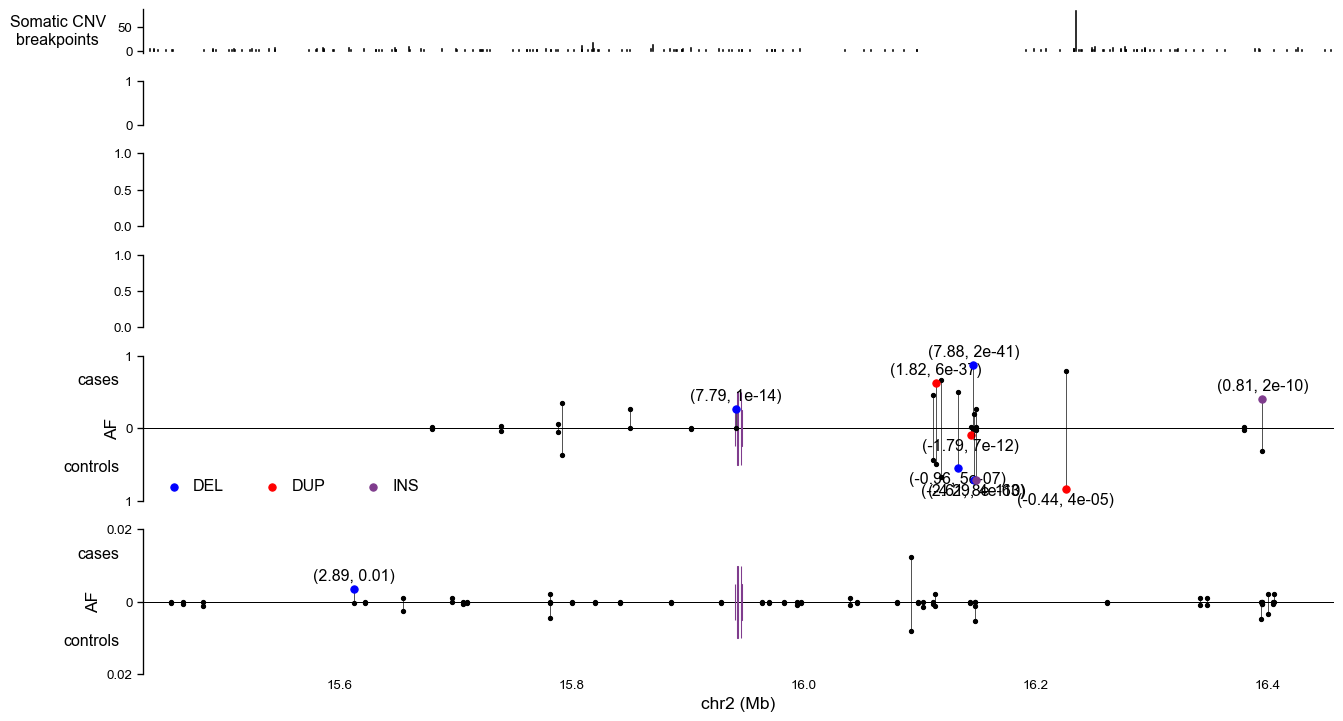

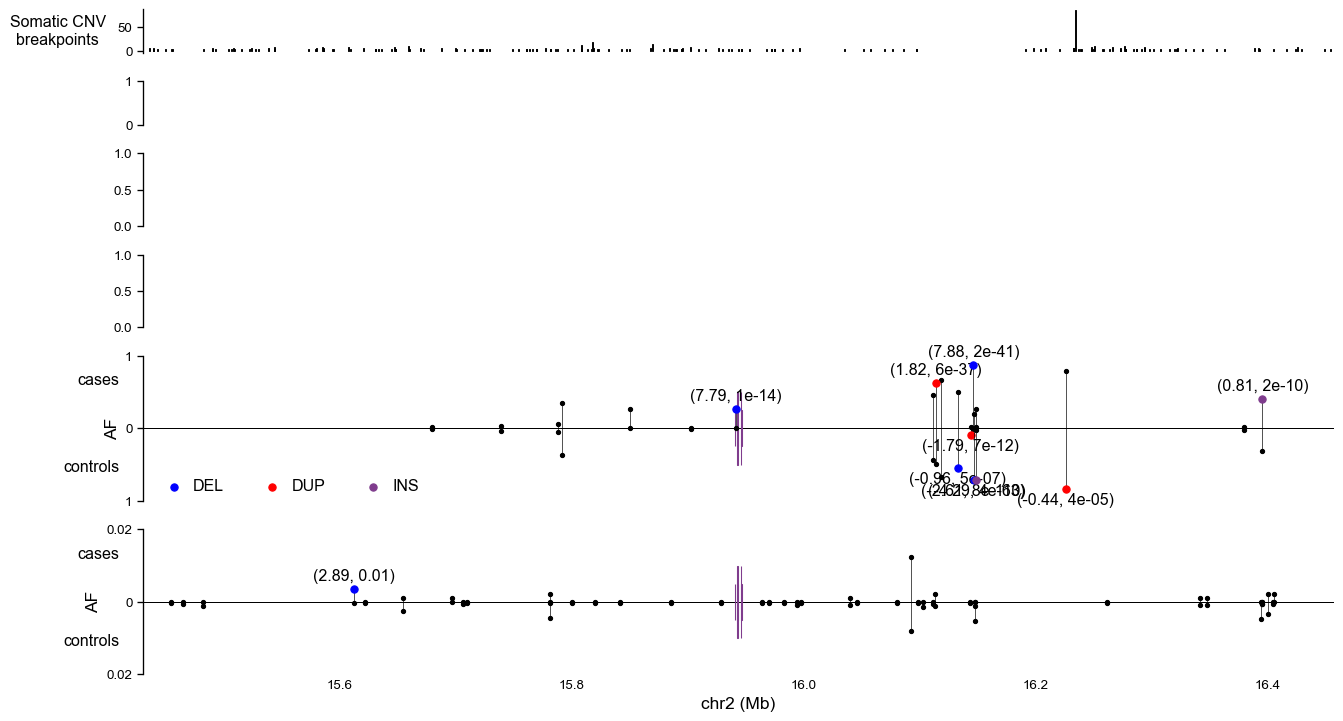

In [70]:
for i in range(2):
    fig, axes = sv_plot_storage[i]
    ax = axes[0]

    for index, row in breakpoints.iterrows():
        x = row['hg38_position']
        y = row['counts']
        ax.plot([x, x], [0, y], color = 'black')

    ax.set_xlim([15440550, 16447007])
    ax.set_ylabel('Somatic CNV\nbreakpoints', rotation = 0, fontsize = 12, labelpad = 45, y = 0.5, va = 'center')
    
    aesthetics.strip_axis(ax, y = 'ignore')
    
    display(fig)

So that cluster of somatic breakpoints is actually somewhat decently separated from nearby structural variants. But because that was array data, it would have been limited by the resolution of the array.

Which begs the question--what are the actual breakpoints? We need WGS (or targetted sequencing).

## Identify somatic breakpoints

https://www-nature-com.ezp-prod1.hul.harvard.edu/articles/s41467-020-18987-4#Sec26

In [71]:
somatic_gistic = pd.read_excel('ref/10.1038-s41467-020-18987-4-supplementary/41467_2020_18987_MOESM5_ESM.xlsx', skiprows = 1)

In [72]:
somatic_gistic[['chrom', 'start', 'end']] = somatic_gistic['Peak Limits'].str.extract('(chr\d+):(\d+)-(\d+)', expand=True)
somatic_gistic[['start', 'end']] = somatic_gistic[['start', 'end']].astype(int)
somatic_gistic['Unique Name'] = somatic_gistic['Unique Name'].apply(lambda s: s.replace(' ', '-'))

In [73]:
gistic_bed = pybedtools.BedTool(
    somatic_gistic[['chrom', 'start', 'end', 'Unique Name', 'q values']].to_csv(sep="\t", index=False, header=False),
    from_string=True,
)

mycn_gistic = gistic_bed.intersect(expanded_gene_bed, wo=True)
mycn_gistic = mycn_gistic.to_dataframe()

In [74]:
mycn_gistic

,chrom,start,end,name,score,strand,thickStart,thickEnd,itemRgb,blockCount
0,chr2,16074875,16091400,Amplification-Peak--4,1.039200e-125,chr2,15440550,16447007,MYCN,16525
1,chr2,16074875,16091400,Amplification-Peak--4---CN-values,1.039200e-125,chr2,15440550,16447007,MYCN,16525


We need the actual breakpoints. PRAYING that they exist.

In [75]:
somatic_bps = pd.read_excel('ref/10.1038-s41467-020-18987-4-supplementary/41467_2020_18987_MOESM6_ESM.xlsx', skiprows = 1)
somatic_bps['unique_id'] = somatic_bps.index

# it's very slow to do it this way, but oh well
mycn_bps = []
window_start, window_end = expanded_gene_locs_hg19.loc['MYCN', ['start', 'end']].values
for index, row in somatic_bps.iterrows():
    left = row[['chr_a', 'position_a']]
    right = row[['chr_b', 'position_b']]
    
    for bp, label in zip([left, right], ['left', 'right']):
        if bp[0] == 2:
            if window_start <= bp[1] <= window_end:
                mycn_bps.append([bp[1], row['unique_id'], label])
                
mycn_bps = pd.DataFrame(mycn_bps, columns = ['position', 'unique_id', 'label'])

mycn_bps = mycn_bps.groupby('position').size().reset_index(name='count')

In [76]:
sliding_window_bps = []
width = 5000
for pos in range(expanded_gene_locs.loc['MYCN', 'start'] + 50, expanded_gene_locs.loc['MYCN', 'end'] + 50, 100):
    start = pos - width/2
    end = pos + width/2
    count = mycn_bps[(mycn_bps['position'] >= start) & (mycn_bps['position'] <= end)]['count'].sum()
    sliding_window_bps.append([pos, count])
    
sliding_window_bps = pd.DataFrame(sliding_window_bps, columns = ['center', 'count'])

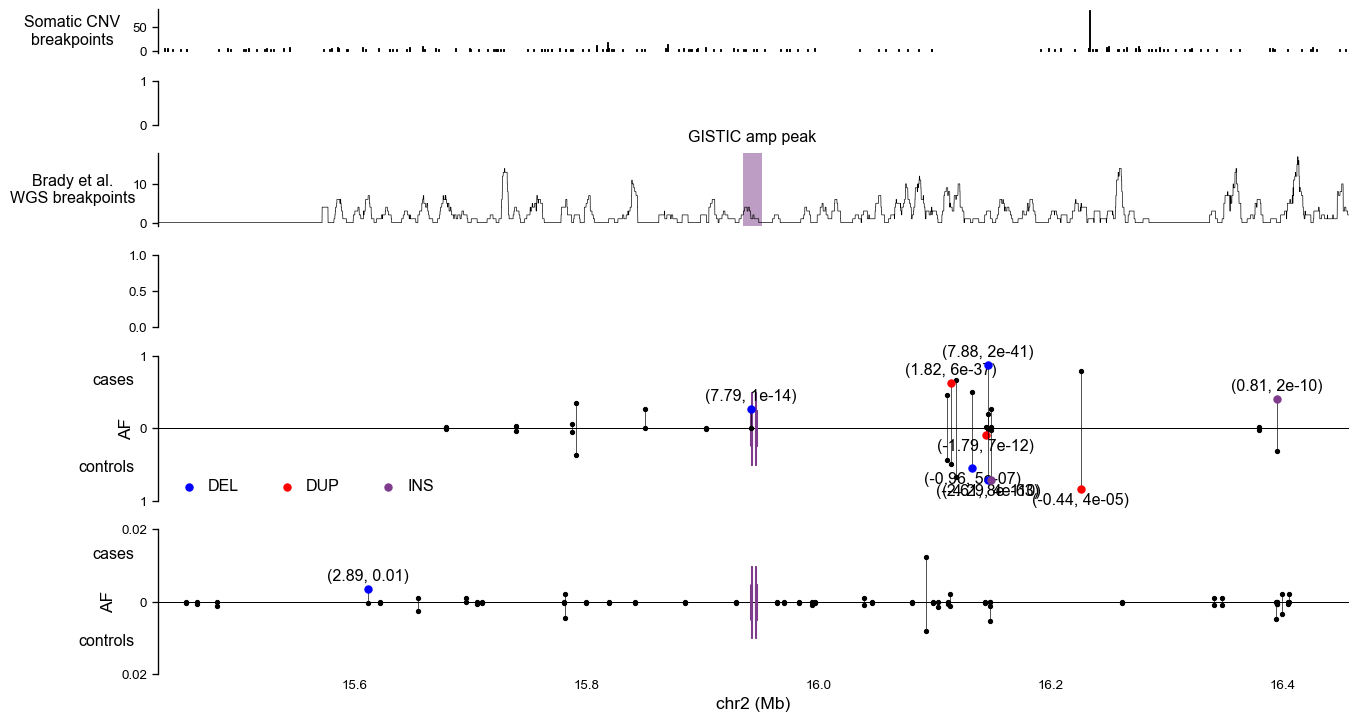

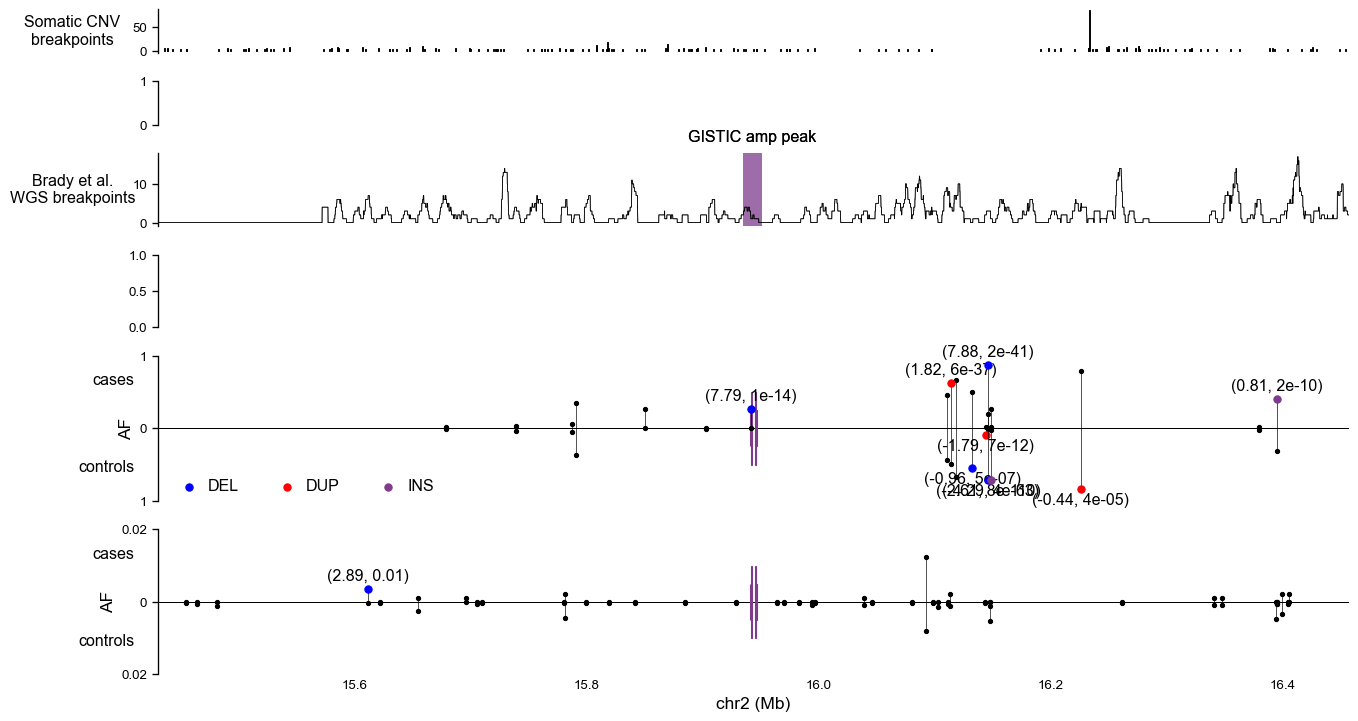

In [77]:
for i in range(2):
    fig, axes = sv_plot_storage[i]
    ax = axes[2]
    
    ax.plot(sliding_window_bps['center'], sliding_window_bps['count'], color = 'black', linewidth = 0.5)

    ax.set_xlim([15440550, 16447007])
    ax.set_ylabel('Brady et al.\nWGS breakpoints', rotation = 0, fontsize = 12, labelpad = 45, y = 0.5, va = 'center')
    
    aesthetics.strip_axis(ax, y = 'ignore')
    
    # GISTIC amp regions
    ax.axvspan(xmin = 15934753, xmax = 15951278, alpha = 0.5)
    ax.text(x = (15934753 + 15951278) / 2, y = 22, s = 'GISTIC amp peak', ha = 'center', va = 'center')
    
    display(fig)

## CN breakpoints for this paper

In [78]:
sv_cnvs = pd.read_excel('ref/10.1038-s41467-020-18987-4-supplementary/41467_2020_18987_MOESM9_ESM.xlsx', skiprows = 1)

# drop CNVs without bases
sv_cnvs = sv_cnvs.dropna(subset = ['loc.start', 'loc.end'], how = 'any')

sv_cnvs['chr'] = 'chr' + sv_cnvs['chr'].astype(str)
sv_cnvs['loc.start'] = sv_cnvs['loc.start'].astype(int)
sv_cnvs['loc.end'] = sv_cnvs['loc.end'].astype(int)

In [79]:
sv_cnvs.head(2)

,sample,chr,loc.start,loc.end,LogRatio,gene,Cnv,keygene2,PLP,in_updated_cohort,source
0,PAPCTS_diagnosis,chr2,15207001,16393500,3.91,MYCN,Amplification,keep,P,yes,Target_WGS_WES_RNA
1,PARIRD_diagnosis,chr2,15332601,17224500,3.47,MYCN,Amplification,keep,P,yes,Target_WGS


In [80]:
cnv_bed = pybedtools.BedTool(
    sv_cnvs[['chr', 'loc.start', 'loc.end', 'LogRatio']].to_csv(sep="\t", index=False, header=False),
    from_string=True,
)

mycn_segments = cnv_bed.intersect(expanded_gene_bed_hg19, wo=True)
mycn_segments = mycn_segments.to_dataframe()

# drop unnecessary columns
mycn_segments = mycn_segments.iloc[:, [0, 1, 2, 3]].copy()
mycn_segments.columns = ["chrom", "start", "end", "logratio"]

In [81]:
breakpoints = mycn_segments['start'].to_list() + mycn_segments['end'].to_list()
breakpoints = pd.DataFrame(breakpoints, columns = ['hg19_position'])

breakpoints = breakpoints.groupby('hg19_position').size().reset_index(name='counts')
breakpoints.head(2)

,hg19_position,counts
0,14491201,1
1,15175102,1


In [82]:
hg19_to_hg38 = get_lifter("hg19", "hg38")

hg38_pos = []
failed_positions = []
for pos in breakpoints['hg19_position']:
    lifted_bp = hg19_to_hg38.query('chr2', pos)
    if len(lifted_bp):
        hg38_pos.append(lifted_bp[0][1])
    else:
        failed_positions.append(pos)
        hg38_pos.append(np.nan)
        
breakpoints['hg38_position'] = hg38_pos

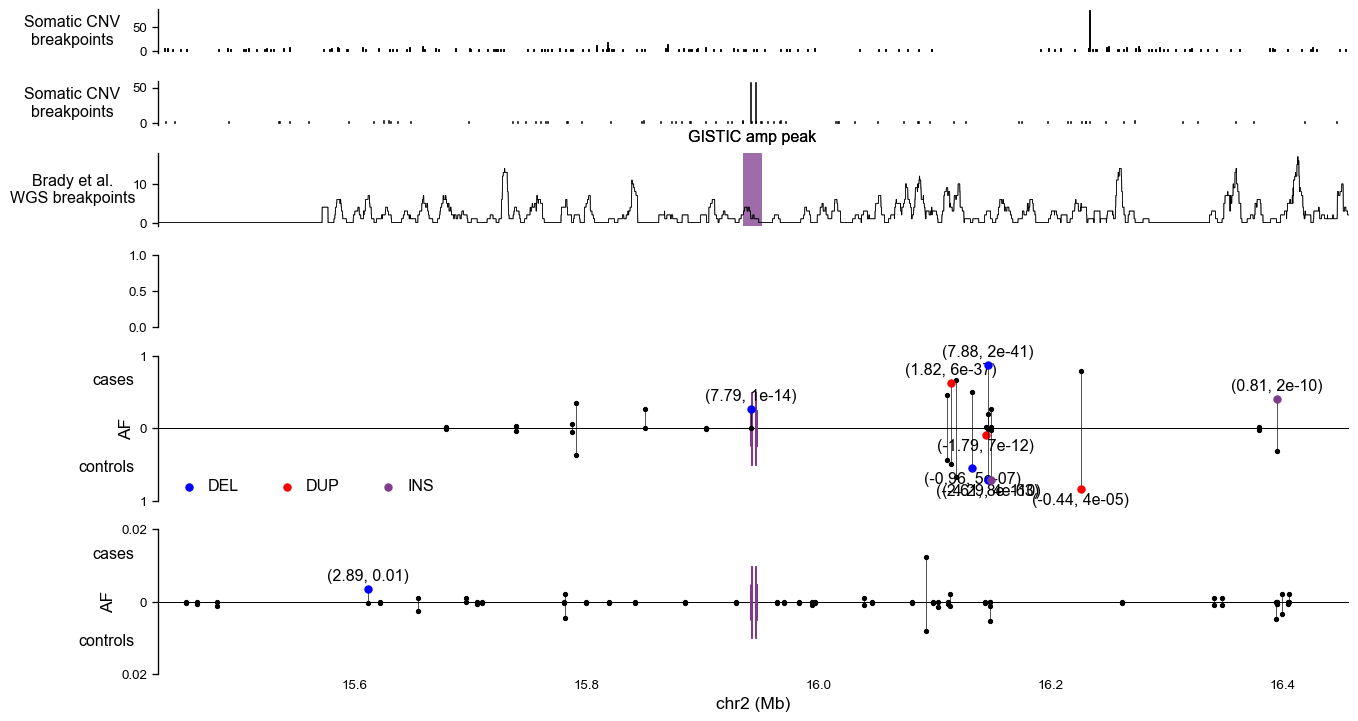

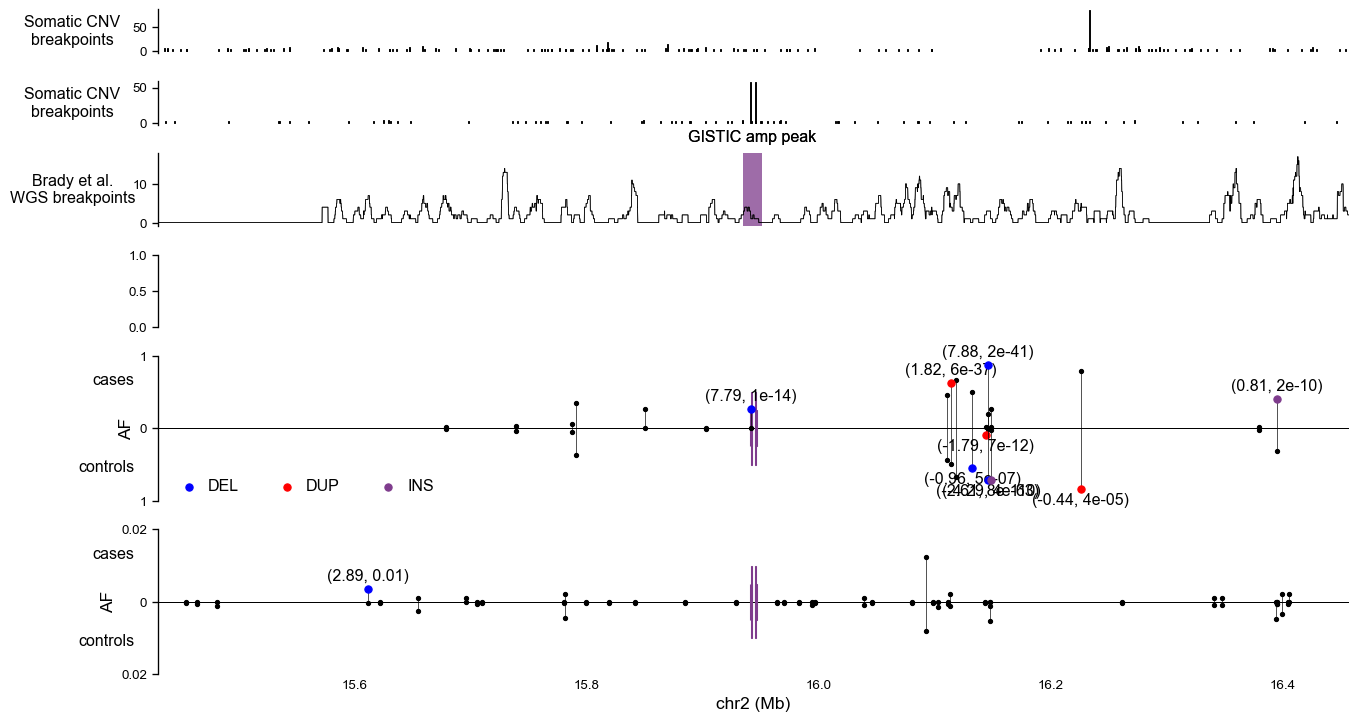

In [83]:
for i in range(2):
    fig, axes = sv_plot_storage[i]
    ax = axes[1]

    for index, row in breakpoints.iterrows():
        x = row['hg38_position']
        y = row['counts']
        ax.plot([x, x], [0, y], color = 'black')

    ax.set_xlim([15440550, 16447007])
    ax.set_ylabel('Somatic CNV\nbreakpoints', rotation = 0, fontsize = 12, labelpad = 45, y = 0.5, va = 'center')
    
    aesthetics.strip_axis(ax, y = 'ignore')
    
    display(fig)

## Some actually good breakpoints

Some data from Riaz! I'm reasonably sure that these are hg38

In [84]:
import re

In [85]:
bps = pd.read_csv('ref/GMKF_NBL_merged_SVs_unfiltered.txt', sep='\t', usecols = range(18))

# drop duplicate bps
bps = bps.drop_duplicates(subset = ['AnnotSV_ID'])
bps['SV_chrom'] = 'chr' + bps['SV_chrom'].astype(str)

/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [86]:
# let's identify SVs in our window
bps_bed = pybedtools.BedTool(
    bps[['SV_chrom', 'SV_start', 'SV_end', 'AnnotSV_ID']].to_csv(sep="\t", index=False, header=False),
    from_string=True,
)

region_somatic_svs = bps_bed.intersect(expanded_gene_bed, wo=True)
region_somatic_svs = region_somatic_svs.to_dataframe()

# get MYCN overlapping SVs
region_somatic_svs = region_somatic_svs.query('chrom == "chr2"')
region_bps = bps[bps['AnnotSV_ID'].isin(region_somatic_svs['name'].to_list())].copy()

# filter down to pass
region_bps = region_bps.query('FILTER == "PASS"')

In [87]:
# some horrific regex to get the MATE
region_bps['MATEID'] = region_bps['INFO'].apply(lambda x: re.search('MATEID=(.*?)(;|$)', x).group(1) if re.search('MATEID=(.*?)(;|$)', x) else None)

# add how many samples had this SV
region_bps['sample_count'] = region_bps['Samples_ID'].apply(lambda x: len(x.split(',')))


Unfortunately, this file is not in the format we need. We need both breakpoints. So we transform it.

In [88]:
def add_breakpoints(row):
    '''Returns two breakpoints as left_chrom, left_pos, right_chrom, right_pos'''
    
    left = [row['SV_chrom'], row['SV_start']]

    if row['SV_type'] in ['INV', 'DEL', 'DUP', 'INS']:
        right = [row['SV_chrom'], row['SV_end']]
        
    elif row['SV_type'] == 'BND':
        right = [None, None]
        
    return left + right

In [89]:
region_bps[['left_chrom', 'left_pos', 'right_chrom', 'right_pos']] = region_bps.apply(add_breakpoints, axis = 1).to_list()

In [90]:
region_bps.head(2)

,AnnotSV_ID,SV_chrom,SV_start,SV_end,SV_length,SV_type,Samples_ID,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,Annotation_mode,CytoBand,Gene_name,Gene_count,MATEID,sample_count,left_chrom,left_pos,right_chrom,right_pos
46112,2_9853257_19302087_DEL_1,chr2,9853257,19302087,-9448829.0,DEL,"BS_0GTTKPSC,BS_T5BAS1JN",MantaDEL:307596:0:1:0:0:0,G,<DEL>,.,PASS,END=19302086;SVTYPE=DEL;SVLEN=-9448829;CIPOS=0...,PR:SR,full,p25.1-p24.1,ATP6V1C2;C2orf50;CYRIA;CYS1;DDX1;E2F6;FLJ33534...,54.0,None,2,chr2,9853257,chr2,19302087.0
46227,2_14287601_15664713_DEL_1,chr2,14287601,15664713,-1377111.0,DEL,"BS_0GTTKPSC,BS_T5BAS1JN",MantaDEL:308768:0:1:0:1:0,G,<DEL>,.,PASS,END=15664712;SVTYPE=DEL;SVLEN=-1377111;CIPOS=0...,PR:SR,full,p24.3,DDX1;LINC00276;LRATD1;NBAS,4.0,None,2,chr2,14287601,chr2,15664713.0


All of these by definition will be on chromosome 2 (or None, if not on chromosome two). So next we gather all breakpoints:

In [91]:
right_bps = region_bps[['AnnotSV_ID', 'right_pos']].rename(columns = {'right_pos': 'pos'})
left_bps = region_bps[['AnnotSV_ID', 'left_pos']].rename(columns = {'left_pos': 'pos'})

all_bps = pd.concat([left_bps, right_bps])

all_bps = all_bps.dropna()

In [92]:
all_bp_locs = all_bps.groupby('pos').size().reset_index(name='counts')
all_bp_locs.head(2)

,pos,counts
0,124174.0,1
1,124380.0,1


Let's do a sliding window.

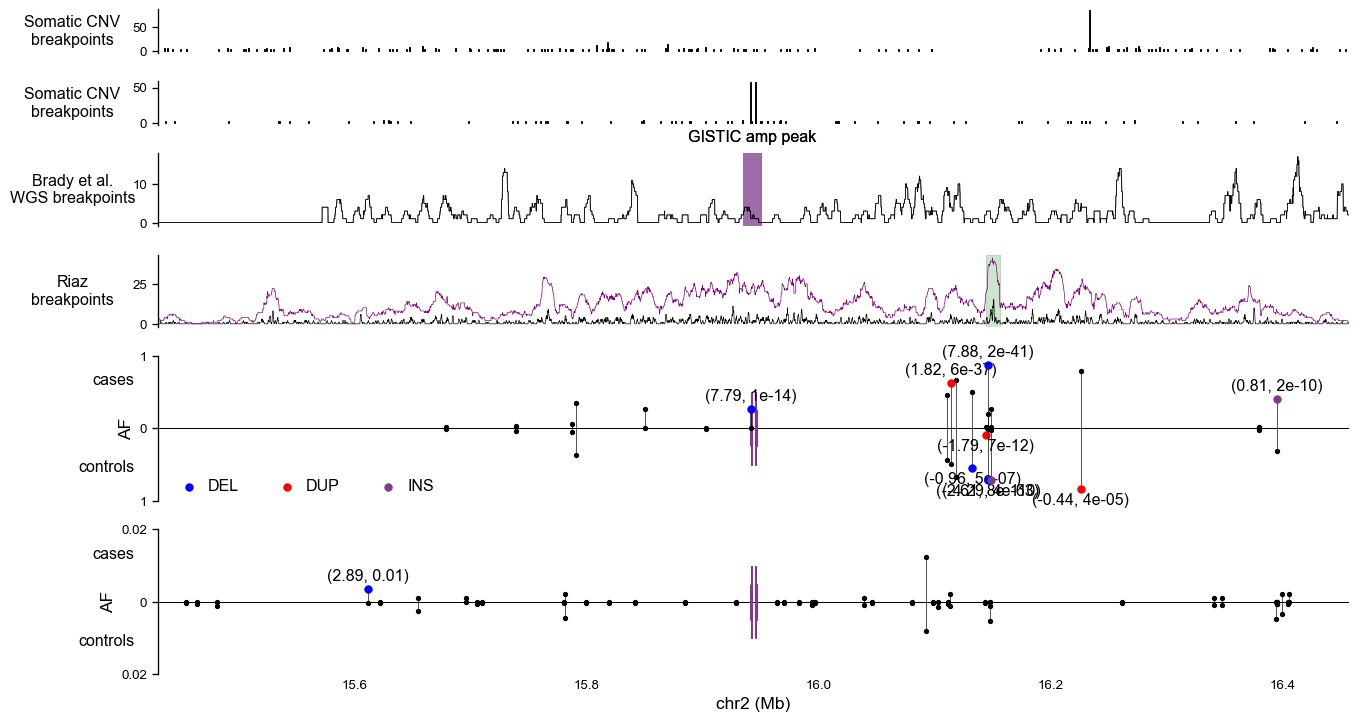

In [93]:
fig, axes = sv_plot_storage[0]
ax = axes[3]

for width in [1000, 10000]:
    sliding_window_bps = []
    label = '1 kb' if width == 1000 else '10 kb'
    color = 'black' if width == 1000 else 'purple'

    for pos in range(expanded_gene_locs.loc['MYCN', 'start'] + 50, expanded_gene_locs.loc['MYCN', 'end'] + 50, 100):
        start = pos - width/2
        end = pos + width/2
        count = all_bp_locs[(all_bp_locs['pos'] >= start) & (all_bp_locs['pos'] <= end)]['counts'].sum()
        sliding_window_bps.append([pos, count])

    sliding_window_bps = pd.DataFrame(sliding_window_bps, columns = ['center', 'count'])

    ax.plot(sliding_window_bps['center'], sliding_window_bps['count'], 
            color = color, linewidth = 0.5, label = label)


ax.set_xlim([15440550, 16447007])
ax.set_ylabel('Riaz\nbreakpoints', rotation = 0, fontsize = 12, 
              labelpad = 45, y = 0.5, va = 'center')

aesthetics.strip_axis(ax, y = 'ignore')

ax.axvspan(xmin = 16140400, xmax = 16152400, alpha = 0.2,
           color = 'green')

display(fig)

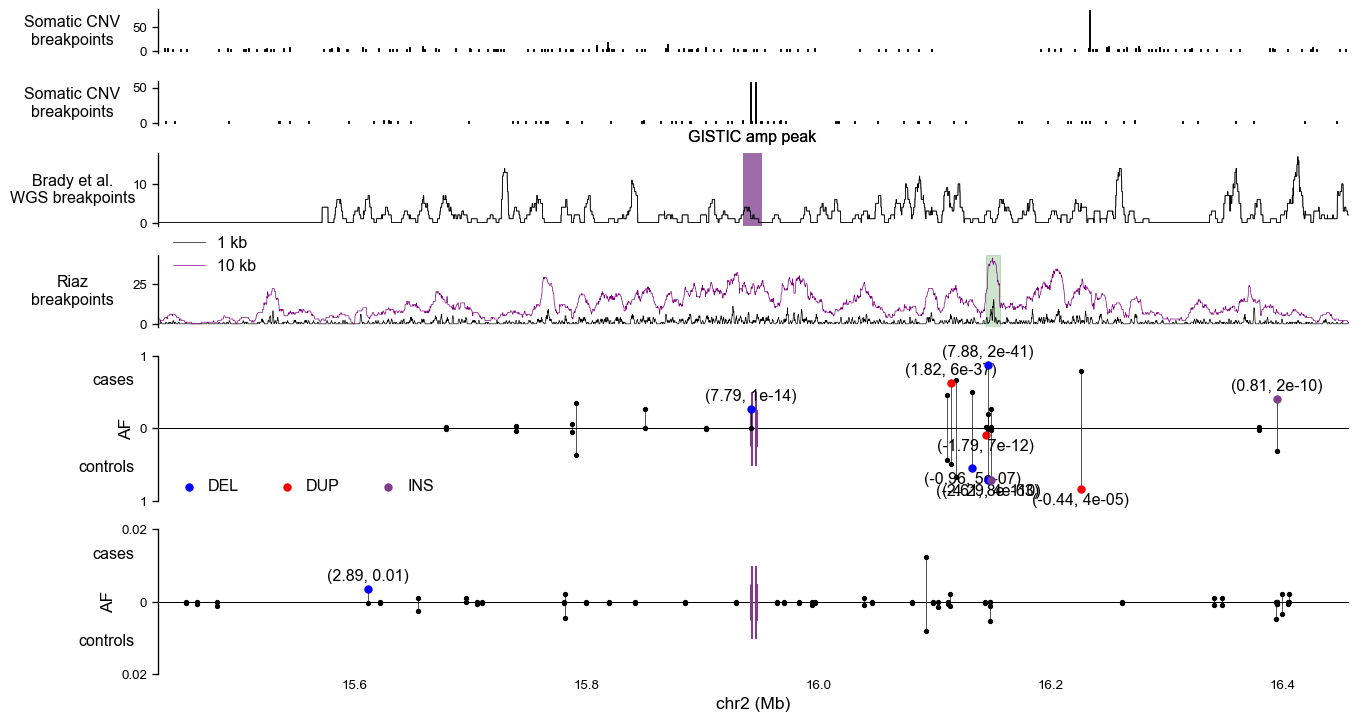

In [94]:
ax.legend(bbox_to_anchor = (0, 1))
display(fig)

In [95]:
fig.savefig('images/neuroblastoma-mycn-somatic-bps-germline-svs.png')

## A quick "association" test

# So what's going on in that region?

In [ ]:
high_region_svs = all_bps[all_bps['pos'].between(16140400, 16152400)]

high_region_svs = region_bps[region_bps['AnnotSV_ID'].isin(high_region_svs['AnnotSV_ID'].to_list())]

# Other studies (unused)

## Pugh et al.

We begin with https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3682833/, a 2013 study that appears to be one of the first exome studies in neuroblastoma. They sequenced 240 cases, with a combination of exome, genome, and transcriptomes. They don't report MYCN amplification rates, but based on their comut, it's on the order of 25%.

Unfortunately, despite extensive digging, they don't actually report any copy number calls or coverage profiles, which is... exceedingly annoying. In fact, they don't even report which samples have a MYCN amplification--this supplement is missing from the paper.

We do get two glimpses of amplification breakpoints in their supplement, where two samples have amplifications--one that has an amplification right around 16 Mb and one that has a wider one, spanning about 0.1 Mb. In either case, these amplifications are quite focal, which is promising for somatic--germline interactions.

## Sausen et al.

This is a 2013 Nature Genetics paper that used CGH to characterize some samples:

https://www-nature-com.ezp-prod1.hul.harvard.edu/articles/ng.2493#MOESM21

## TARGET

This paper was a sequencing effort coordinated to study neuroblastoma: https://www.cancer.gov/ccg/research/genome-sequencing/target/studied-cancers/neuroblastoma.

Some data related to this project is actually stored in ICGC: https://dcc.icgc.org/releases/release_28/Projects/NBL-US. They have _some_ form of copy number provided there, although I think it's CGH, which doesn't bode well for exact breakpoint identification. Oh well, we'll see.

## Others (some to try in here!)

https://www-nature-com.ezp-prod1.hul.harvard.edu/articles/s41598-020-78370-7#Sec30
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5593593/
https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0273280
https://cancerci.biomedcentral.com/articles/10.1186/s12935-018-0521-3
https://ega-archive.org/studies/EGAS00001001184 (on EGA)
https://aacrjournals-org.ezp-prod1.hul.harvard.edu/clincancerres/article/24/4/939/81206/Whole-Exome-Sequencing-of-Cell-Free-DNA-Reveals
https://www.mdpi.com/2075-4426/11/12/1286?type=check_update&version=1
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2877825/

We can also just get seg files from cbioportal

https://www.cbioportal.org/study/cnSegments?id=nbl_target_2018_pub


https://pubmed.ncbi.nlm.nih.gov/26466568/ (suggests also looking at TERT)
- This study does not provide any structural variant calls

https://www-nature-com.ezp-prod1.hul.harvard.edu/articles/nature10910#Sec19
- This paper provides "junction calls" which presumably represent structural variants, so we could take those.